# DICOM RT Tool Example for Manuscript

This version is for the Technical Paper by Brian Anderson.

Last edited by Kareem Wahid on January 3, 2020.

This notebook demonstrates the various functions and utilities avaliable in the Dicom RT tool package (https://github.com/brianmanderson/Dicom_RT_and_Images_to_Mask). It does so by working through an example of an oropharyngeal cancer case that contains a DICOM formated T2-w MRI sequence (120 files) and corresponding RT structure file (1 file) with multiple segmented regions of interest (primary tumor, lymph nodes, left parotid, right parotid, left cheek fat, right cheek fat). 

The notebook covers the following topics:
1. Reading in DICOM and RT struct files and converting to numpy array format. 
2. Saving arrays to nifti format. 
3. Saving and loading numpy files for later use. 

This notebook uses publically avaliable data from the following link: LINK.

The notebook assumes you have the following directory structure:

In [1]:
"""
DICOMRTTool_example/
│   DICOMRTTool.ipynb
│
└───DICOM/
│       120 DICOM files (UID.dcm)
│       1 RT struct file (str.dcm)
└───nifti/
│       MRN_Path_To_Iteration.xlsx (created after running notebook)
│       Overall_Data__0.nii (created after running notebook)
|       Overall_mask__y0.nii (created after running notebook)
└───numpy/
│       image.npy (created after running notebook)
│       mask.npy (created after running notebook)
"""

'\nDICOMRTTool_example/\n│   DICOMRTTool.ipynb\n│\n└───DICOM/\n│       120 DICOM files (UID.dcm)\n│       1 RT struct file (str.dcm)\n└───nifti/\n│       MRN_Path_To_Iteration.xlsx (created after running notebook)\n│       Overall_Data__0.nii (created after running notebook)\n|       Overall_mask__y0.nii (created after running notebook)\n└───numpy/\n│       image.npy (created after running notebook)\n│       mask.npy (created after running notebook)\n'

In [2]:
# importing neccessary libraries
from DicomRTTool.ReaderWriter import DicomReaderWriter # pip install DicomRTTool
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os 

In [3]:
def display_slices(image, mask):
    """
    Displays a series of slices that contains the segmented regions of interest. 
        Parameters:
            image (array-like): numpy array of image 
            mask (array-like): numpy array of mask
        Returns:
            None (series of in-line plots)
    """

    slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
    slice_start = slice_locations[0] # first slice of contour 
    slice_end = slice_locations[len(slice_locations)-1] # last slice of contour
    
    for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): # plot the slices with contours overlayed ontop
        masked_contour_arr = np.ma.masked_where(contour_arr == 0, contour_arr)
        plt.imshow(img_arr, cmap='gray', interpolation='none')
        plt.imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.5, vmin = 1, vmax = np.amax(mask)) # vmax is set as total number of contours so same colors can be displayed for each slice
        plt.show()

## Part 1: Reading in DICOM and RT struct files and converting to numpy array format.
The principal on which these set of tools operates on is based on the DicomReaderWriter object. It is instantiated with the contours of interest (and associations) and can then be used to create numpy arrays of images and masks of the format [slices, width, height].

To extrapolate the following code logic to a arbitrary folder structure, one could use an os.walk through directories of interest. For example, I normally use a folder structure MRN -> date of image (pre,mid,post-RT) -> type of scan (MRI, CT, etc.) -> files.

In [4]:
DICOM_path = os.path.join('.', 'DICOM') # go into DICOM subfolder 

In [6]:
Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
Dicom_reader.walk_through_folders(DICOM_path) # need to define in order to use all_roi method

Index 0, description Axial - Arterial Phase  2.0  MIP at H:\Modular_Projects\DicomRTWork\New_Data\Mixed
Index 1, description Arterial Phase  5.0  I40f  3 at H:\Modular_Projects\DicomRTWork\New_Data\Mixed
2 unique series IDs were found. Default is index 0, to change use set_index(index)


In [7]:
all_rois = Dicom_reader.return_rois(print_rois=True)  # Return a list of all rois present, and print them

The following ROIs were found
external
liver_bma_program_4


In [12]:
Contour_Names = ["GTV_p", "GTV_n1", "Parotid_R", "Parotid_L"] 

associations = {'GTV_p_KW':'GTV_p','GTV_p_KW_SA':'GTV_p', # just to show an example of how associations works
               'GTV_n1_KW_SA': 'GTV_n1'}

In [13]:
Dicom_reader.set_contour_names(Contour_Names)
Dicom_reader.__set_associations__(associations)

Lacking ['gtv_p', 'gtv_n1', 'parotid_r', 'parotid_l', 'liver_bma_program_4'] in index 0, location H:\Modular_Projects\DicomRTWork\New_Data\Mixed. Found []
Lacking ['gtv_p', 'gtv_n1', 'parotid_r', 'parotid_l'] in index 1, location H:\Modular_Projects\DicomRTWork\New_Data\Mixed. Found ['external', 'liver_bma_program_4']


In [14]:
Dicom_reader.set_index(0)  # Default, you can change as you like
Dicom_reader.get_images_and_mask()  # Load up the images and mask for the requested index

Loading images for Arterial Phase  5.0  I40f  3 at 
 H:\Modular_Projects\DicomRTWork\New_Data\Mixed



In [15]:
image = Dicom_reader.ArrayDicom # image array
mask = Dicom_reader.mask # mask array

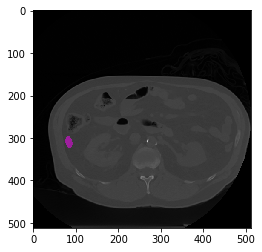

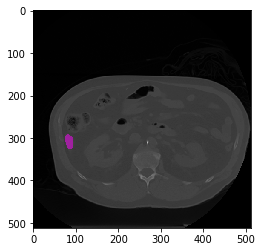

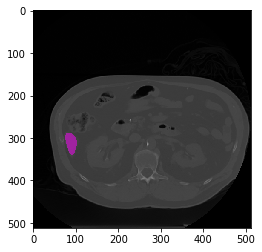

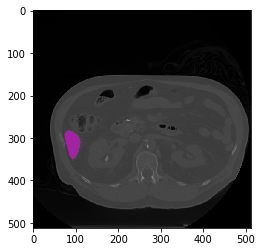

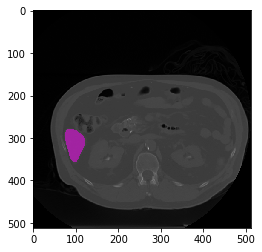

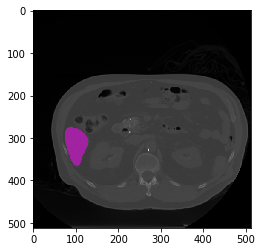

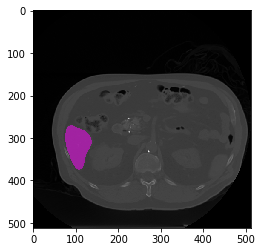

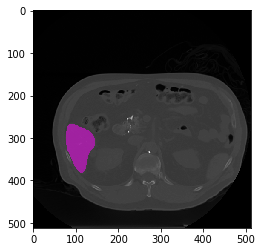

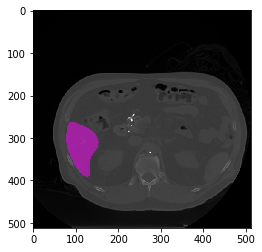

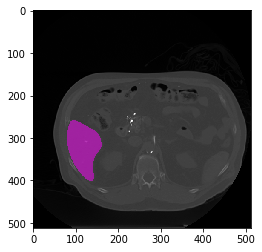

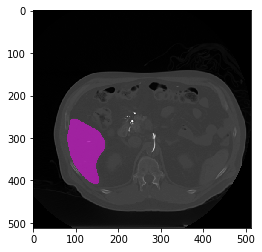

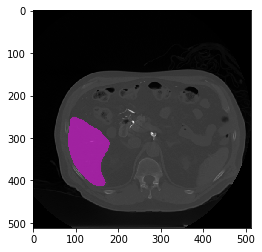

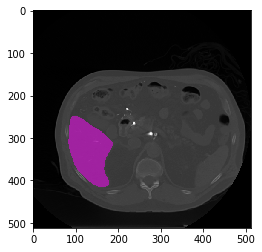

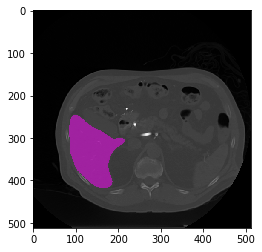

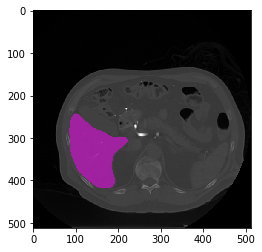

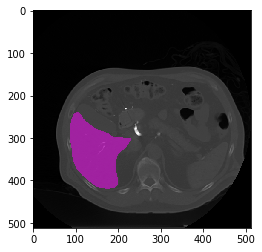

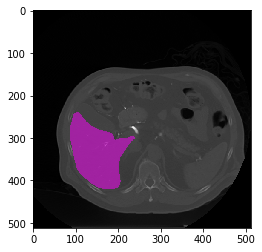

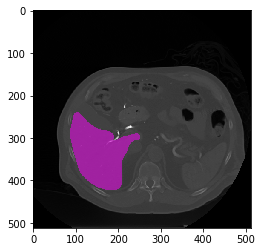

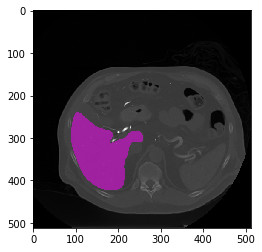

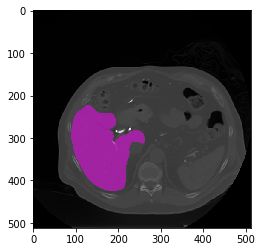

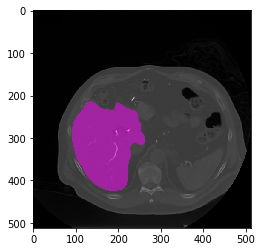

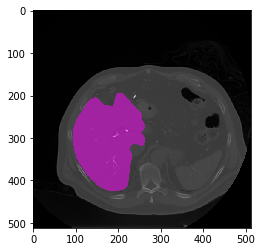

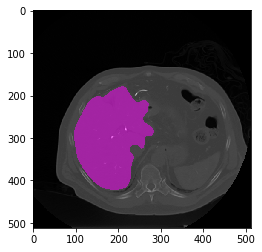

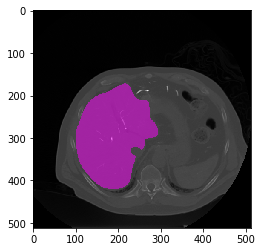

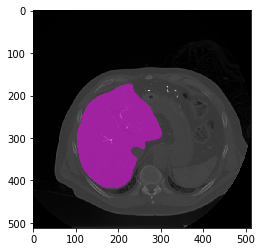

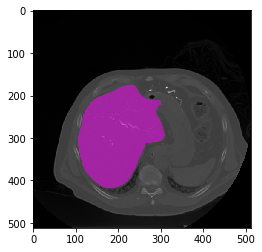

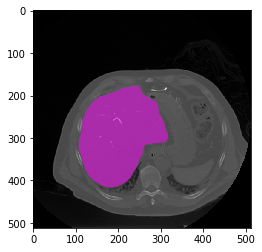

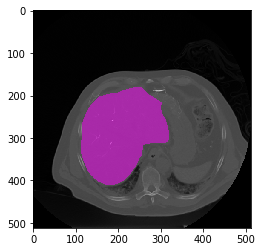

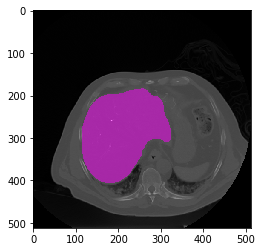

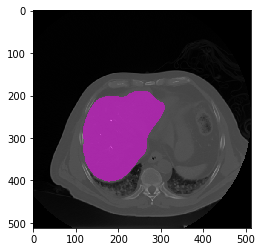

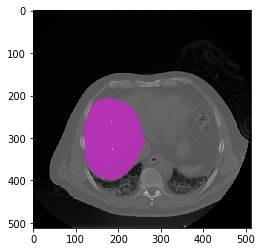

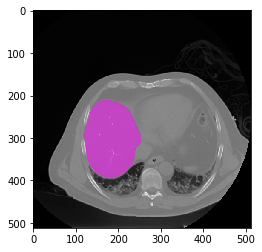

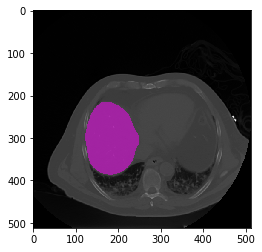

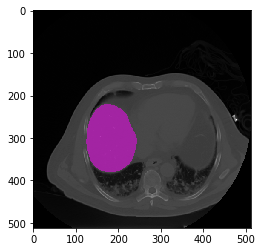

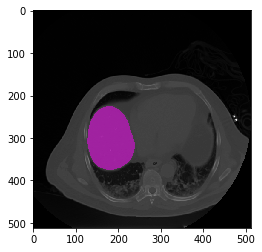

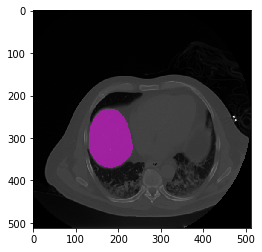

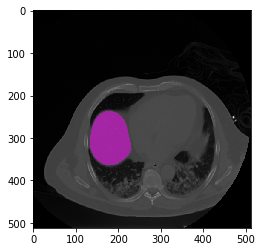

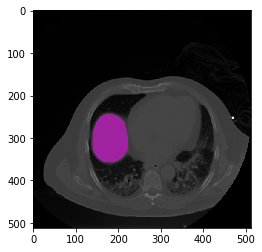

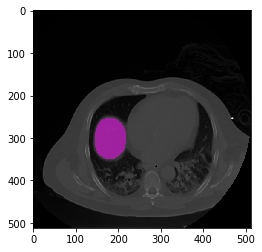

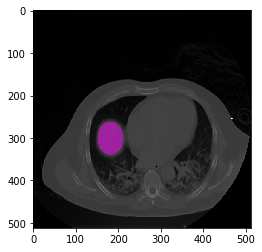

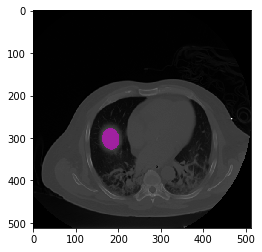

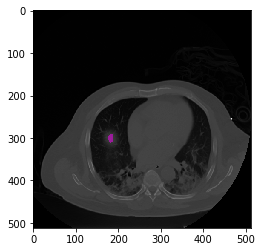

In [17]:
display_slices(image, mask) # visualize that our segmentations were succesfully convereted 

## Part 2: Saving arrays to nifti format.

The write_parallel method genereates a Overall_Data (image) file and Overall_mask file with the corresponding execution number. It can be used for any arbitrary image modality or arbitrary number of contours. Takes a few seconds per patient. 

Note the nifti writer creates a log .txt file in each DICOM folder and a corresponding log excel file in the specified output path. 

In [18]:
nifti_path = os.path.join('.', 'nifti') # go into nifti subfolder 

In [19]:
Dicom_reader.write_parallel(out_path = nifti_path, excel_file = os.path.join(nifti_path,'.','MRN_Path_To_Iteration.xlsx'))

Lacking ['gtv_p', 'gtv_n1', 'parotid_r', 'parotid_l', 'liver_bma_program_4'] in index 0, location H:\Modular_Projects\DicomRTWork\New_Data\Mixed. Found []
Lacking ['gtv_p', 'gtv_n1', 'parotid_r', 'parotid_l'] in index 1, location H:\Modular_Projects\DicomRTWork\New_Data\Mixed. Found ['external', 'liver_bma_program_4']


## Part 3: Saving and loading numpy files for later use. 

Finally we can save the numpy arrays to files for later use (so you don't have to reinstantiate the computationally expensive DicomReaderWriter object) and subsequently re-load the numpy arrays.

In [ ]:
numpy_path = os.path.join('.', 'numpy') # go into numpy subfolder 

In [ ]:
np.save(os.path.join(numpy_path,'image'), image) # save the arrays
np.save(os.path.join(numpy_path,'mask'), mask)

In [ ]:
image = np.load(os.path.join(numpy_path,'image.npy')) # load the arrays
mask = np.load(os.path.join(numpy_path,'mask.npy'))

## Part 4: TEst

In [ ]:
xxx = 1